In [1]:
%matplotlib inline

import nltk
import sklearn
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from spellchecker import SpellChecker
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sentence_transformers import SentenceTransformer, util
from ydata_profiling import ProfileReport

## Load data

In [2]:
DATA_DIR = "../data/commonlit-evaluate-student-summaries/"
prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

In [3]:
train = summaries_train.join(prompts_train.set_index("prompt_id"), on="prompt_id", how="left")
test_data = summaries_test.join(prompts_test.set_index("prompt_id"), on="prompt_id", how="left")

In [4]:
train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


In [5]:
test_data.head()

,student_id,prompt_id,text,prompt_question,prompt_title,prompt_text
0,000000ffffff,abc123,Example text 1,Summarize...,Example Title 1,Heading\nText...
1,111111eeeeee,def789,Example text 2,Summarize...,Example Title 2,Heading\nText...
2,222222cccccc,abc123,Example text 3,Summarize...,Example Title 1,Heading\nText...
3,333333dddddd,def789,Example text 4,Summarize...,Example Title 2,Heading\nText...


## Evaluation

In [6]:
def mcrmse(target, prediction):
    assert type(target) == np.ndarray, "Target must be numpy array"
    assert type(prediction) == np.ndarray, "Prediction must be numpy array"
    assert target.shape == prediction.shape, "Target and prediction must have the same shape"
    columns = np.sqrt(np.sum(np.power(target-prediction, 2), axis=0)/target.shape[0])
    return np.sum(columns, axis=0)/target.shape[1]

In [7]:
mcrmse(train[['content', 'wording']].to_numpy(), train[['content', 'wording']].to_numpy())

0.0

## Data preparation

In [8]:
ProfileReport(train)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/mykyta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mykyta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
def process_text(text):
    text = text.lower()
    tokens = nltk.tokenize.word_tokenize(text)
    
    # Remove punctuation
    tokens = [word for word in tokens if word.isalnum()]

    # Remove stopwords, so rare words have more influance at content score
    tokens = [token for token in tokens if token not in stop_words]

    # Stem tokens to lower vocab size
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    
    return ' '.join(stemmed_tokens)

In [11]:
train['processed_prompt'] = train['prompt_text'].apply(process_text)
train['processed_text'] = train['text'].apply(process_text)

In [12]:
raw_prompt_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['prompt_text']))
processed_prompt_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['processed_prompt']))
raw_text_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['text']))
processed_text_word_cloud = WordCloud(width=800, height=400).generate(" ".join(train['processed_text']))

### Prompt word cloud:

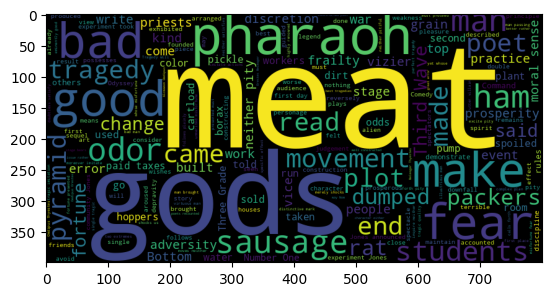

In [13]:
plt.imshow(raw_prompt_word_cloud);

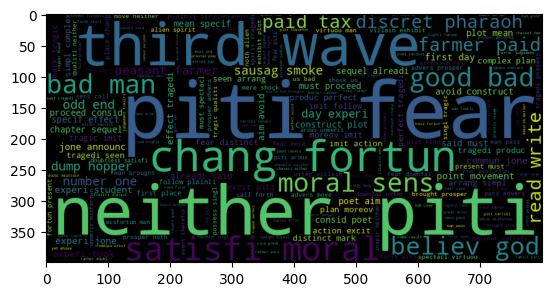

In [14]:
plt.imshow(processed_prompt_word_cloud);

### Text word cloud:

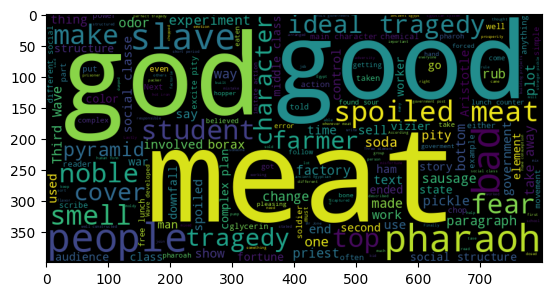

In [15]:
plt.imshow(raw_text_word_cloud);

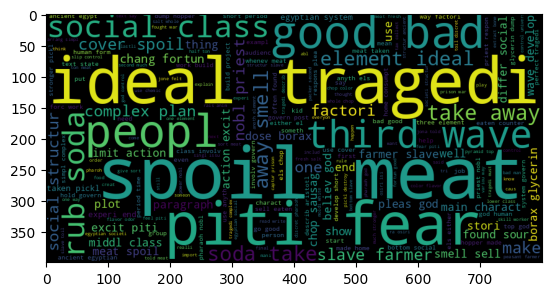

In [16]:
plt.imshow(processed_text_word_cloud);

Text processing made word distribution more even

In [17]:
train['prompt_len'] = train['processed_prompt'].apply(len)
train['text_len'] = train['processed_text'].apply(len)

In [18]:
train[['text_len', 'prompt_len', 'content', 'wording']].corr()

,text_len,prompt_len,content,wording
text_len,1.000000,0.027883,0.797507,0.539919
prompt_len,0.027883,1.000000,-0.018732,-0.087100
content,0.797507,-0.018732,1.000000,0.751380
wording,0.539919,-0.087100,0.751380,1.000000


Text len is very correlated with content score, but not with wording. Try add features that influance wording score

In [19]:
spell_checker = SpellChecker()
def misspeled_word_count(text):
    return len(spell_checker.unknown(text.split(" ")))

In [20]:
# Counting words in text to find content similarity between text and prompt
def word_overlap_count(prompt, text):
    return len([1 for word in text.split(" ") if word in prompt.split(' ')])

In [21]:
# Counting total len of quotes, because text with qoutes from prompt could have better content score
def quotes_len(text):
    return sum([len(qoute) for qoute in(re.findall(r'"([^"]*)"', text))])

In [22]:
# Counting mean word len in text, since longer word could correlate with better scores
def mean_word_len(text):
    return np.mean([len(word) for word in text.split(" ")])

In [23]:
# Texts with more unique words can have better content score
def unique_word_count(text):
    return len(set(text.split(" ")))

In [24]:
def add_all_features(df):
    df['processed_prompt'] = df['prompt_text'].apply(process_text)
    df['processed_text'] = df['text'].apply(process_text)
    
    df['prompt_len'] = df['processed_prompt'].apply(len)
    df['text_len'] = df['processed_text'].apply(len)
    
    # Counting misspaled words in a raw text, so text processing would not delete or add mistakes
    df['misspeled_word_count'] = df['text'].apply(misspeled_word_count)
    
    df['word_overlap_count'] = df.apply(lambda row: word_overlap_count(row['processed_prompt'], row['processed_text']), axis=1)
    df['quotes_len'] = df['text'].apply(quotes_len)

    # Counting word len in prompt, because if prompt is easy then text doesn't need to have long words 
    df['prompt_mean_word_len'] = df['processed_prompt'].apply(mean_word_len)
    df['text_mean_word_len'] = df['processed_text'].apply(mean_word_len)

    # Same reason for unique words
    df['prompt_unique_word_count'] = df['processed_prompt'].apply(unique_word_count)
    df['text_unique_word_count'] = df['processed_text'].apply(unique_word_count)

In [25]:
add_all_features(train)

In [26]:
train[['text_len', 'misspeled_word_count', 'word_overlap_count', 'quotes_len', 'text_mean_word_len', 'text_unique_word_count', 'content', 'wording']].corr()

,text_len,misspeled_word_count,word_overlap_count,quotes_len,text_mean_word_len,text_unique_word_count,content,wording
text_len,1.000000,0.897745,0.930002,0.617672,0.120059,0.975868,0.797507,0.539919
misspeled_word_count,0.897745,1.000000,0.860183,0.639313,0.105673,0.893439,0.697696,0.416466
word_overlap_count,0.930002,0.860183,1.000000,0.688027,-0.011200,0.924995,0.701668,0.360036
quotes_len,0.617672,0.639313,0.688027,1.000000,-0.088748,0.608540,0.419206,0.156464
text_mean_word_len,0.120059,0.105673,-0.011200,-0.088748,1.000000,0.067432,0.132739,0.151498
text_unique_word_count,0.975868,0.893439,0.924995,0.608540,0.067432,1.000000,0.794251,0.520515
content,0.797507,0.697696,0.701668,0.419206,0.132739,0.794251,1.000000,0.751380
wording,0.539919,0.416466,0.360036,0.156464,0.151498,0.520515,0.751380,1.000000


Text len still has most influance at wording score, try using vectorization

## Train test split

Selecting one prompt to validate

In [27]:
test_prompt_id = train['prompt_id'][0]

In [28]:
X_train = train[train['prompt_id'] != test_prompt_id].reset_index(drop=True)
y_train = X_train[['content', 'wording']]
X_train = X_train.drop(columns = ['content', 'wording'])

X_test = train[train['prompt_id'] == test_prompt_id].reset_index(drop=True)
y_test = X_test[['content', 'wording']]
X_test = X_test.drop(columns = ['content', 'wording'])

Building cross validation iterator. Selecting one prompt to test cross validation, training on the rest:

In [29]:
cv_itarator = []
for prompt_id in set(X_train['prompt_id'].to_numpy()):
    train_ids = X_train[X_train['prompt_id'] != prompt_id].index.values
    test_ids = X_train[X_train['prompt_id'] == prompt_id].index.values
    cv_itarator.append((train_ids, test_ids))

## Vectorization
### Sentence embeding
Calculating cos similarity to find how similar text and prompt, since it porbably influance content score

In [30]:
content_vectorizer = SentenceTransformer('paraphrase-MiniLM-L3-v2')

def get_prompt_text_similarity(prompts, texts):
    similarities = []
    encoded_prompts = content_vectorizer.encode(prompts)
    encoded_texts = content_vectorizer.encode(texts)
    for prompt, text in zip(encoded_prompts, encoded_texts):
        similarities.append(util.cos_sim(prompt, text).item())
    return np.array(similarities).reshape(-1, 1)

In [31]:
prompt_text_similarity_train = get_prompt_text_similarity(X_train['processed_prompt'], X_train['processed_text'])
prompt_text_similarity_test = get_prompt_text_similarity(X_test['processed_prompt'], X_test['processed_text'])

### TF-IDF
Using char analyzer and ngram_range to search for misspaling in syllabels instead of words to lower vocab size. Using tfidf vectorizer so rare syllabels (mistakes) would have higher weight

In [32]:
wording_vectorizer = TfidfVectorizer(analyzer='char', lowercase=True, strip_accents='ascii', ngram_range=(2, 4))

In [33]:
wording_vectorizer.fit(X_train['text'])

TfidfVectorizer(analyzer='char', ngram_range=(2, 4), strip_accents='ascii')

In [34]:
text_wording_vectorized_train = wording_vectorizer.transform(X_train['text']).toarray()
text_wording_vectorized_test = wording_vectorizer.transform(X_test['text']).toarray()

## Modeling
Using two models: one to predict content score and another to predict wording

In [35]:
CONTENT_FEATURES = [
    'text_len',
    'word_overlap_count',
    'quotes_len',
    'prompt_mean_word_len',
    'text_mean_word_len',
    'prompt_unique_word_count',
    'text_unique_word_count'
]

WORDING_FEATURES = ['text_len', 'misspeled_word_count']

In [36]:
content_scaler = StandardScaler()
content_scaler.fit(X_train[CONTENT_FEATURES])
wording_scaler = StandardScaler()
wording_scaler.fit(X_train[WORDING_FEATURES])

StandardScaler()

In [37]:
# Prepare content data
X_train_content_sparse = np.hstack([
    prompt_text_similarity_train,
    content_scaler.transform(X_train[CONTENT_FEATURES])
])
X_test_content_sparse = np.hstack([
    prompt_text_similarity_test,
    content_scaler.transform(X_test[CONTENT_FEATURES])
])

# Prepare wording data
X_train_wording_sparse = np.hstack([
    text_wording_vectorized_train,
    wording_scaler.transform(X_train[WORDING_FEATURES])
])
X_test_wording_sparse = np.hstack([
    text_wording_vectorized_test,
    wording_scaler.transform(X_test[WORDING_FEATURES])
])

In [38]:
content_model_params = {'num_leaves': [15, 31, 60], 'max_depth': [3, 5, 7]}
wording_model_params = {'num_leaves': [15, 31, 60], 'max_depth': [3, 5, 7]}
content_model = GridSearchCV(LGBMRegressor(n_jobs=-1, verbosity=-1), param_grid=content_model_params, cv=cv_itarator, scoring='neg_root_mean_squared_error', verbose=3)
wording_model = GridSearchCV(LGBMRegressor(n_jobs=-1, verbosity=-1), param_grid=wording_model_params, cv=cv_itarator, scoring='neg_root_mean_squared_error', verbose=3)

### Fit models

In [39]:
content_model.fit(X_train_content_sparse, y_train['content'], eval_metric='rmse')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END .......max_depth=3, num_leaves=15;, score=-0.502 total time=   0.0s
[CV 2/3] END .......max_depth=3, num_leaves=15;, score=-0.519 total time=   0.0s
[CV 3/3] END .......max_depth=3, num_leaves=15;, score=-0.577 total time=   0.0s
[CV 1/3] END .......max_depth=3, num_leaves=31;, score=-0.502 total time=   0.0s
[CV 2/3] END .......max_depth=3, num_leaves=31;, score=-0.519 total time=   0.0s
[CV 3/3] END .......max_depth=3, num_leaves=31;, score=-0.577 total time=   0.0s
[CV 1/3] END .......max_depth=3, num_leaves=60;, score=-0.502 total time=   0.0s
[CV 2/3] END .......max_depth=3, num_leaves=60;, score=-0.519 total time=   0.0s
[CV 3/3] END .......max_depth=3, num_leaves=60;, score=-0.577 total time=   0.0s
[CV 1/3] END .......max_depth=5, num_leaves=15;, score=-0.507 total time=   0.0s
[CV 2/3] END .......max_depth=5, num_leaves=15;, score=-0.524 total time=   0.0s
[CV 3/3] END .......max_depth=5, num_leaves=15;, 

GridSearchCV(cv=[(array([   0,    1,    2, ..., 6058, 6059, 6061]),
                  array([   6,    7,   11, ..., 6044, 6054, 6060])),
                 (array([   1,    2,    4, ..., 6058, 6059, 6060]),
                  array([   0,    3,    5, ..., 6053, 6057, 6061])),
                 (array([   0,    3,    5, ..., 6057, 6060, 6061]),
                  array([   1,    2,    4, ..., 6056, 6058, 6059]))],
             estimator=LGBMRegressor(n_jobs=-1, verbosity=-1),
             param_grid={'max_depth': [3, 5, 7], 'num_leaves': [15, 31, 60]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [40]:
wording_model.fit(X_train_wording_sparse, y_train['wording'], eval_metric='rmse')

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END .......max_depth=3, num_leaves=15;, score=-0.703 total time=  10.2s
[CV 2/3] END .......max_depth=3, num_leaves=15;, score=-0.756 total time=  10.2s
[CV 3/3] END .......max_depth=3, num_leaves=15;, score=-0.916 total time=   9.2s
[CV 1/3] END .......max_depth=3, num_leaves=31;, score=-0.703 total time=  10.0s
[CV 2/3] END .......max_depth=3, num_leaves=31;, score=-0.756 total time=  10.1s
[CV 3/3] END .......max_depth=3, num_leaves=31;, score=-0.916 total time=   9.2s
[CV 1/3] END .......max_depth=3, num_leaves=60;, score=-0.703 total time=  10.0s
[CV 2/3] END .......max_depth=3, num_leaves=60;, score=-0.756 total time=  10.1s
[CV 3/3] END .......max_depth=3, num_leaves=60;, score=-0.916 total time=   9.3s
[CV 1/3] END .......max_depth=5, num_leaves=15;, score=-0.698 total time=  12.2s
[CV 2/3] END .......max_depth=5, num_leaves=15;, score=-0.773 total time=  12.0s
[CV 3/3] END .......max_depth=5, num_leaves=15;, 

GridSearchCV(cv=[(array([   0,    1,    2, ..., 6058, 6059, 6061]),
                  array([   6,    7,   11, ..., 6044, 6054, 6060])),
                 (array([   1,    2,    4, ..., 6058, 6059, 6060]),
                  array([   0,    3,    5, ..., 6053, 6057, 6061])),
                 (array([   0,    3,    5, ..., 6057, 6060, 6061]),
                  array([   1,    2,    4, ..., 6056, 6058, 6059]))],
             estimator=LGBMRegressor(n_jobs=-1, verbosity=-1),
             param_grid={'max_depth': [3, 5, 7], 'num_leaves': [15, 31, 60]},
             scoring='neg_root_mean_squared_error', verbose=3)

### Grid search results
Content model:

In [41]:
content_model.best_params_

{'max_depth': 3, 'num_leaves': 15}

Wording model:

In [42]:
wording_model.best_params_

{'max_depth': 3, 'num_leaves': 15}

### Models score:

In [43]:
content_prediction = content_model.predict(X_test_content_sparse)
content_score = sklearn.metrics.mean_squared_error(y_test['content'], content_prediction, squared=False)
content_score

0.5458097261106374

In [44]:
wording_prediction = wording_model.predict(X_test_wording_sparse)
wording_score = sklearn.metrics.mean_squared_error(y_test['wording'], wording_prediction, squared=False)
wording_score

0.9224012807595178

In [45]:
total_score = (content_score + wording_score) / 2
total_score

0.7341055034350776

## Test data prediction

In [46]:
add_all_features(test_data)

In [47]:
test_data_similarity = get_prompt_text_similarity(test_data['processed_prompt'], test_data['processed_text'])

In [48]:
test_data_text_vectorized = wording_vectorizer.transform(test_data['text']).toarray()

In [49]:
test_data_content_sparse = np.hstack([
    test_data_similarity,
    content_scaler.transform(test_data[CONTENT_FEATURES])
])
test_data_wording_sparse = np.hstack([
    test_data_text_vectorized,
    wording_scaler.transform(test_data[WORDING_FEATURES])
])

In [50]:
test_content_prediction = content_model.predict(test_data_content_sparse)
test_wording_prediction = wording_model.predict(test_data_wording_sparse)

In [51]:
result = pd.concat((test_data['student_id'], pd.DataFrame({'content': test_content_prediction, 'wording': test_wording_prediction})), axis=1)

In [52]:
result

,student_id,content,wording
0,000000ffffff,-1.430458,-1.295771
1,111111eeeeee,-1.430458,-1.295771
2,222222cccccc,-1.430458,-1.295771
3,333333dddddd,-1.430458,-1.295771
